In [1]:
train_path = "Data/covid.train.csv"  # 训练集存储路径
test_path = "Data/covid.test.csv"  # 测试集存储路径

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
myseed = 42069  # 创作随机数种子
torch.backends.cudnn.deterministic = True  # 每次返回的卷积算法将是确定的，即默认算法
torch.backends.cudnn.benchmark = False  # 设定不用自行探索卷积算法
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


In [3]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record,title="Learning Curve Figure"):
    """本函数用于绘制学习曲线"""
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)  # 生成x轴坐标
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]  # 每隔x个输出一个值
    figure(figsize=(6,4))  # 指定画布大小
    plt.plot(x_1,loss_record['train'],c='tab:red',label='train')  # 绘制训练过程中的训练集的损失
    plt.plot(x_2,loss_record['dev'],c='tab:cyan',label='dev')  # 绘制训练过程中的验证集的损失
    plt.ylim(0.0,5.0)
    plt.xlabel("Training steps")
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()  # 显示刻度
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()


In [4]:
class CovidDataset(Dataset):
    def __init__(self,path,mode='train',target_only=False):
        self.mode = mode
        data = pd.read_csv(path)  # 读取数据
        data = np.array(data)[:,1:].astype(float)  # 将数据转化为array格式
        if not target_only:
            feats = list(range(93))  # 特征列的列号列表(因为最后一列是标签)
        else:
            pass
        if mode=='test':  # 进入测试模式
            data = data[:,feats]
            self.data = torch.FloatTensor(data)  # 将数据转化为张量并存储起来
        else:  # 进入训练模式或者验证模式
            target = data[:,-1]  # 拿到target
            data = data[:,feats]  # 拿到features
            if mode == 'train':
                """每十行抽一个数据出来做验证集"""
                indices = [i for i in range(len(data)) if i%10!=0]
            else:
                indices = [i for i in range(len(data)) if i % 10 == 0]
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
        """对40列以后的数据做Mean-Std标准化"""
        self.data[:, 40:] = (self.data[:, 40:]-self.data[:, 40:].mean(dim=0,keepdim=True))/self.data[:, 40:].std(dim=0,keepdim=True)
        self.dim = self.data.shape[1]  # 返回特征列数
        print("数据集制作完成")
    
    def __getitem__(self, index):
        if self.mode in ['train','dev']:
            """训练和验证模式下返回特征和标签"""
            return self.data[index],self.target[index]
        else:
            """测试模式下只返回特征"""
            return self.data[index]
    
    def __len__(self):
        return self.data.shape[0]

In [5]:
def prep_dataloader(path,mode,batch_size,n_jobs=0,target_only=False):
    dataset = CovidDataset(path=path,mode=mode,target_only=target_only)  # 实例化一个数据集
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=(mode=='train'),drop_last=False,num_workers=n_jobs,
                            pin_memory=True)
    return dataloader

In [6]:
class NeuralNet(nn.Module):
    def __init__(self,input_dim):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_dim,64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64,1)
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x
    
    def cal_loss(self,pred,target):
        return self.criterion(pred,target)


In [7]:
def train(tr_set,dv_set,model,config,device):
    n_epochs = config['n_epochs']  # epochs最大值
    optimizer = getattr(torch.optim,config['optimizer'])(model.parameters(),**config['optim_hparas'])  # 获取优化器
    min_mse = 1000
    loss_record = {'train':[],'dev':[]}  # 生成字典嵌套列表来记录损失值
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()  # 让模型进入训练模式
        for x,y in tr_set:  # 从dataloader里拿到数据
            optimizer.zero_grad()  # 清空优化器中的梯度值
            x, y = x.to(device),y.to(device)  # 将数据存储到指定device中
            pred = model(x)  # 执行forward方法
            mse_loss = model.cal_loss(pred,y)  # 计算本轮训练得出来的损失值
            mse_loss.backward()  # 计算梯度
            optimizer.step()  # 根据计算出来的梯度更新模型参数，更新模型
            loss_record['train'].append(mse_loss.detach().cpu().item())  # 存储损失值
        
        """每轮epoch跑完之后,要使用验证集进行验证"""
        dev_mse = dev(dv_set,model,device)
        if dev_mse < min_mse:
            """如果模型验证结果比目前最优结果要好,则应该保留本轮epoch的参数"""
            min_mse = dev_mse  # 更新目前最优模型结果
            print("保存局部最优模型,epoch={:4d},loss={:.4f}".format(epoch+1, min_mse))
            torch.save(model.state_dict(),config['save_path'])  # 保存当前模型在指定路径下
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        epoch += 1
        loss_record['dev'].append(dev_mse)  # 存储当前验证集的损失
        if early_stop_cnt > config['early_stop']:
            break
    print("在经过{}epoch后完成训练".format(epoch))
    return min_mse,loss_record


In [8]:
def test(tt_set,model,device):
    model.eval()  # 进入验证模式
    preds = list()
    for x in tt_set:
        x = x.to(device)
        with torch.no_grad():  # 验证这部分无需梯度
            pred = model(x)  # 执行forward函数
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds,dim=0).numpy()
    return preds

In [9]:
def dev(dv_set,model,device):
    model.eval()  # 设定模型进入验证模式
    total_loss = 0
    for x,y in dv_set:
        x,y = x.to(device),y.to(device)
        with torch.no_grad():  # 验证这部分无需梯度
            pred = model(x)  # 执行forward函数
            mse_loss = model.cal_loss(pred,y)  # 计算验证集的损失
        total_loss += mse_loss.detach().cpu().item() * len(x)  # 计算总损失值
    total_loss = total_loss/len(dv_set.dataset)  # 计算平均损失
    return total_loss


In [10]:
device = get_device()  # 获得当前算法运行机器
os.makedirs('models',exist_ok=True)  # 生成models文件夹来存储局部最优模型
target_only = False
config = {
    'n_epochs': 3000,                # 设定epochs最大值
    'batch_size': 270,               # 设定batch-size
    # optimization algorithm (optimizer in torch.optim)
    'optimizer': 'SGD',
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    # early stopping epochs (the number epochs since your model's last improvement)
    'early_stop': 200,
    'save_path': 'models/model.pth'  # your model will be saved here
}


In [11]:
tr_set = prep_dataloader(
    train_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(
    train_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(
    test_path, 'test', config['batch_size'], target_only=target_only)
model = NeuralNet(tr_set.dataset.dim).to(
    device)  # Construct model and move to device


数据集制作完成
数据集制作完成
数据集制作完成


In [12]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)


f:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([270])) that is different to the input size (torch.Size([270, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


保存局部最优模型,epoch=   1,loss=144.7356
保存局部最优模型,epoch=   2,loss=80.6683
保存局部最优模型,epoch=   3,loss=72.8719
保存局部最优模型,epoch=   4,loss=67.6927
保存局部最优模型,epoch=   5,loss=65.2459
保存局部最优模型,epoch=   6,loss=63.6977
保存局部最优模型,epoch=   7,loss=62.4508
保存局部最优模型,epoch=   8,loss=61.8533
保存局部最优模型,epoch=   9,loss=61.1960
保存局部最优模型,epoch=  10,loss=60.8745
保存局部最优模型,epoch=  11,loss=60.5770
保存局部最优模型,epoch=  12,loss=60.3909
保存局部最优模型,epoch=  13,loss=60.1961
保存局部最优模型,epoch=  14,loss=60.0483
保存局部最优模型,epoch=  15,loss=59.9338
保存局部最优模型,epoch=  16,loss=59.8195
保存局部最优模型,epoch=  17,loss=59.7245
保存局部最优模型,epoch=  18,loss=59.6790
保存局部最优模型,epoch=  20,loss=59.5582
保存局部最优模型,epoch=  21,loss=59.4640
保存局部最优模型,epoch=  22,loss=59.4020
保存局部最优模型,epoch=  23,loss=59.3791
保存局部最优模型,epoch=  25,loss=59.3005
保存局部最优模型,epoch=  26,loss=59.2624
保存局部最优模型,epoch=  28,loss=59.2133
保存局部最优模型,epoch=  29,loss=59.1890
保存局部最优模型,epoch=  32,loss=59.1575
保存局部最优模型,epoch=  33,loss=59.1372
保存局部最优模型,epoch=  36,loss=59.1281
保存局部最优模型,epoch=  37,loss=59.1120
保存局部最优模型,

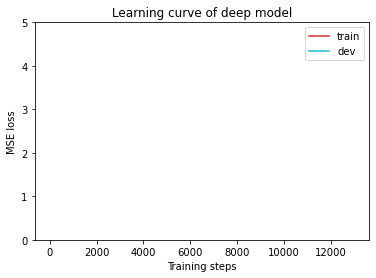

In [13]:
plot_learning_curve(model_loss_record, title='deep model')


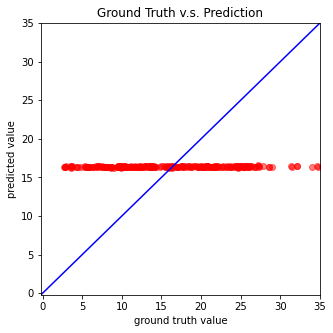

In [14]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # 载入现存的最好模型
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set


In [15]:
import csv
def save_pred(preds, file):
    ''' 保存预测结果'''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])


preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv


Saving results to pred.csv
